**Imports & Setup**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
METRICS_SUMMARY_PATH = "./model_metrics_summary.csv"
CONFUSION_MATRICES_PATH = "./confusion_matrices_summary.csv"
FIGURE_DIR = "./figures"

MODEL_LABELS = {
    "cnn": "Convolutional Neural Network",
    "svm": "Support Vector Machine",
    "knn": "k-Nearest Neighbors",
    "decision_tree_forest": "Decision Tree Forest",
}

MODEL_COLORS = {
    "decision_tree_forest": "tab:green",
    "knn": "tab:purple",
    "svm": "tab:blue",
    "cnn": "tab:red",
}

**Analysis Tables & Graphics**

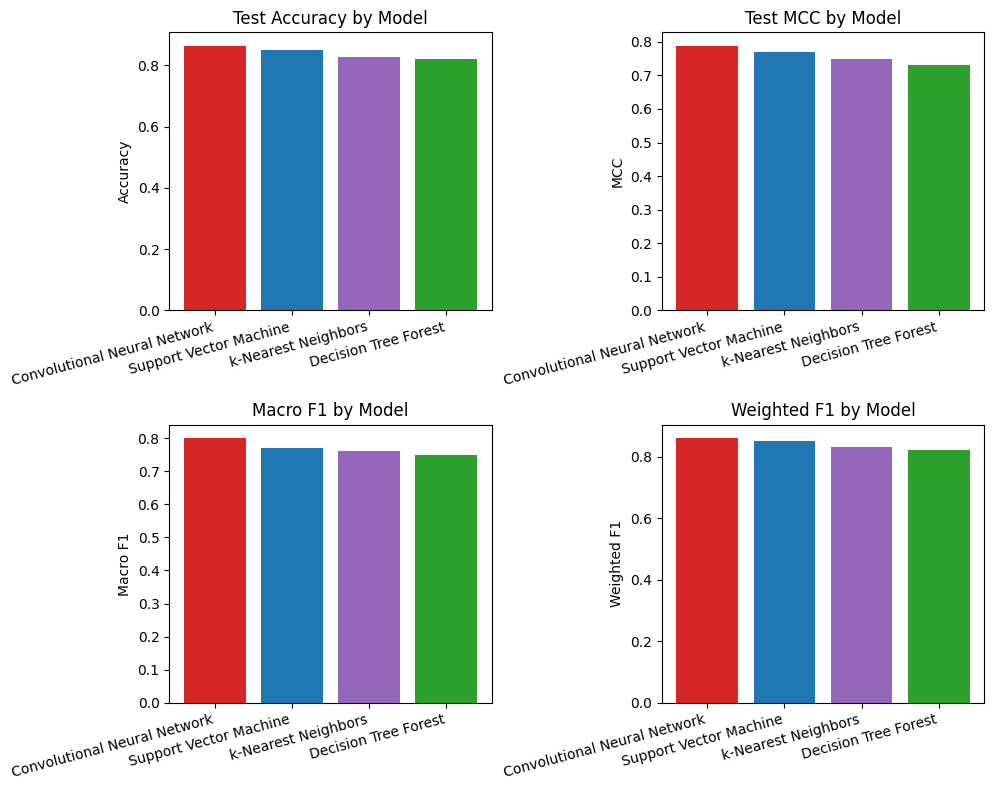

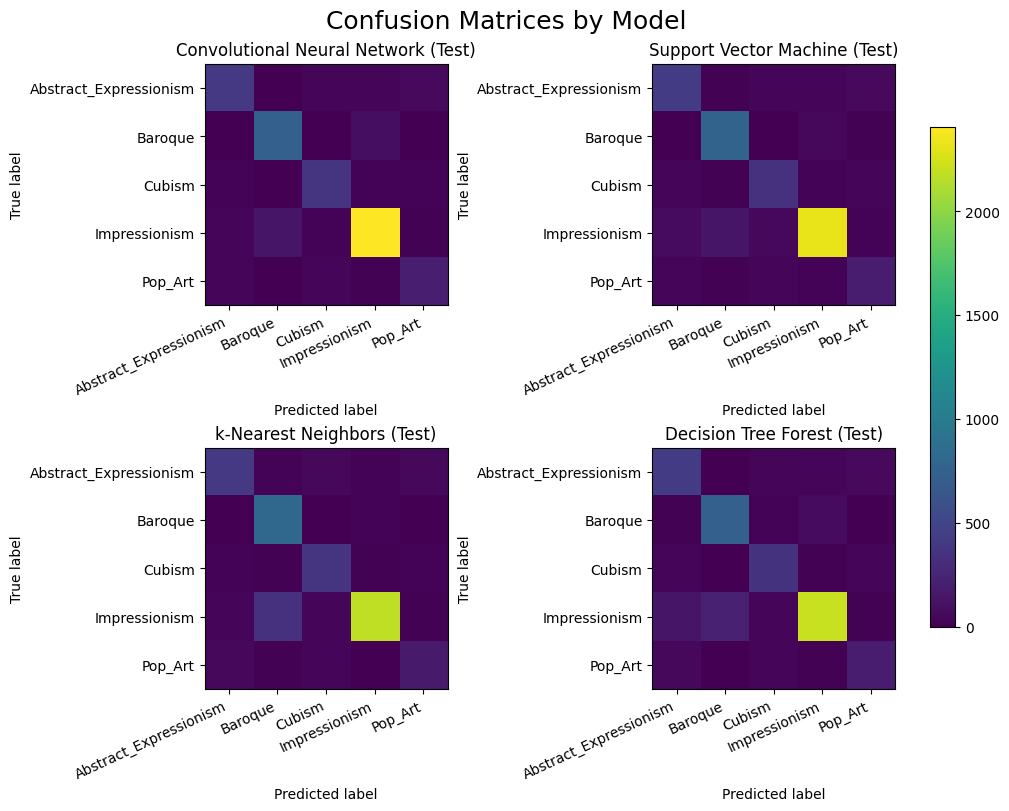


Per-class metrics estimated from confusion matrices:


,model,class,precision,recall,f1,support
0,decision_tree_forest,Abstract_Expressionism,0.628788,0.745063,0.682005,557
1,decision_tree_forest,Baroque,0.754582,0.873821,0.809836,848
2,decision_tree_forest,Cubism,0.723926,0.791946,0.756410,447
3,decision_tree_forest,Impressionism,0.944278,0.843415,0.891001,2612
4,decision_tree_forest,Pop_Art,0.629630,0.629630,0.629630,297
5,knn,Abstract_Expressionism,0.769231,0.718133,0.742804,557
6,knn,Baroque,0.672442,0.961085,0.791262,848
7,knn,Cubism,0.723108,0.812081,0.765016,447
8,knn,Impressionism,0.965075,0.835758,0.895773,2612
9,knn,Pop_Art,0.667925,0.595960,0.629893,297



Worst class prediction per model (lowest recall):
- Decision Tree Forest: Pop_Art (recall = 0.630)
- k-Nearest Neighbors: Pop_Art (recall = 0.596)
- Support Vector Machine: Pop_Art (recall = 0.623)
- Convolutional Neural Network: Pop_Art (recall = 0.684)

Top 5 confusions for best model (Convolutional Neural Network):


,true_class,pred_class,count
0,Impressionism,Baroque,133
1,Baroque,Impressionism,89
2,Abstract_Expressionism,Pop_Art,59
3,Abstract_Expressionism,Cubism,47
4,Pop_Art,Abstract_Expressionism,44


In [14]:
# load data
summary_df = pd.read_csv(METRICS_SUMMARY_PATH)
confusion_df = pd.read_csv(CONFUSION_MATRICES_PATH)

# sort summary by mcc & fix labels
summary_sorted = summary_df.sort_values("test_mcc", ascending=False).reset_index(drop=True)
summary_sorted["model_pretty"] = summary_sorted["model"].map(MODEL_LABELS)

# bar charts for overall metrics, combined in one figure
metrics = [
    ("test_accuracy", "Test Accuracy by Model", "Accuracy"),
    ("test_mcc", "Test MCC by Model", "MCC"),
    ("macro_f1", "Macro F1 by Model", "Macro F1"),
    ("weighted_f1", "Weighted F1 by Model", "Weighted F1"),
]

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
x_labels = summary_sorted["model_pretty"]
x_pos = np.arange(len(x_labels))
bar_colors = [MODEL_COLORS[m] for m in summary_sorted["model"]]
for ax, (col, title, ylabel) in zip(axes, metrics):
    values = summary_sorted[col]
    ax.bar(x_pos, values, color=bar_colors)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=15, ha="right")

fig.tight_layout()
plot_path = FIGURE_DIR + "/overall_metrics.png"
plt.savefig(plot_path, bbox_inches='tight', dpi=150)
plt.show()

# heatmaps for confusion matrices, combined in one figure
models = summary_df["model"].unique()
classes = confusion_df["true_class"].unique().tolist()

def get_confusion_matrix_for_model(model_name):
    sub = confusion_df[confusion_df["model"] == model_name]
    cm = sub.pivot(index="true_class", columns="pred_class", values="count")
    cm = cm.reindex(index=classes, columns=classes)
    return cm.values, cm.index.tolist(), cm.columns.tolist()

ordered_models = summary_sorted["model"].tolist()
fig_cm, axes_cm = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
axes_cm = axes_cm.flatten()
fig_cm.suptitle("Confusion Matrices by Model", fontsize=18)

# scale vmin/vmax across all models
vmin = 0
vmax = 0
cms_for_plot = {}
for m in ordered_models:
    cm, row_labels, col_labels = get_confusion_matrix_for_model(m)
    cms_for_plot[m] = (cm, row_labels, col_labels)
    vmax = max(vmax, cm.max())
for ax, m in zip(axes_cm, ordered_models):
    cm, row_labels, col_labels = cms_for_plot[m]
    im = ax.imshow(cm, interpolation="nearest", aspect="auto", vmin=vmin, vmax=vmax)
    pretty_name = MODEL_LABELS.get(m, m)
    ax.set_title(f"{pretty_name} (Test)")
    tick_marks = np.arange(len(row_labels))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(col_labels, rotation=25, ha="right")
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(row_labels)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")


fig_cm.colorbar(im, ax=axes_cm, location="right", shrink=0.8)
plot_path = FIGURE_DIR + "/confusion_matrices.png"
plt.savefig(plot_path, bbox_inches='tight', dpi=150)
plt.show()

# metrics per class from confusion matrices
def per_class_metrics_from_cm(cm, class_names):
    cm = np.asarray(cm)
    tp = np.diag(cm)
    support = cm.sum(axis=1)
    pred_pos = cm.sum(axis=0)
    recall = tp / np.maximum(support, 1)
    precision = tp / np.maximum(pred_pos, 1)
    f1 = 2 * precision * recall / np.maximum(precision + recall, 1e-12)
    return pd.DataFrame({
        "class": class_names,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "support": support,
    })

per_class_tables = []
for m in models:
    cm, row_labels, col_labels = get_confusion_matrix_for_model(m)
    metrics_df = per_class_metrics_from_cm(cm, row_labels)
    metrics_df.insert(0, "model", m)
    per_class_tables.append(metrics_df)
per_class_all = pd.concat(per_class_tables, ignore_index=True)
print("\nPer-class metrics estimated from confusion matrices:")
display(per_class_all)

# analysis of errors .. hardest class per model
print("\nWorst class prediction per model (lowest recall):")
for m in models:
    df_m = per_class_all[per_class_all["model"] == m]
    worst_row = df_m.sort_values("recall").iloc[0]
    pretty_name = MODEL_LABELS.get(m, m)
    print(f"- {pretty_name}: {worst_row['class']} (recall = {worst_row['recall']:.3f})")

best_model_name = summary_df.sort_values("test_mcc", ascending=False)["model"].iloc[0]
best_pretty = MODEL_LABELS.get(best_model_name, best_model_name)
best_cm, _, _ = get_confusion_matrix_for_model(best_model_name)
NUM = 5
cm_best = best_cm.copy()
np.fill_diagonal(cm_best, 0)
flat_idx = np.argsort(cm_best.ravel())[::-1]
rows = []
for idx in flat_idx[:NUM]:
    i = idx // cm_best.shape[1]
    j = idx % cm_best.shape[1]
    rows.append({
        "true_class": classes[i],
        "pred_class": classes[j],
        "count": int(cm_best[i, j]),
    })

top_confusions_df = pd.DataFrame(rows)
print(f"\nTop {NUM} confusions for best model ({best_pretty}):")
display(top_confusions_df)

